In [17]:
import numpy as np 
from datasets import load_dataset
import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt

# Problem 1
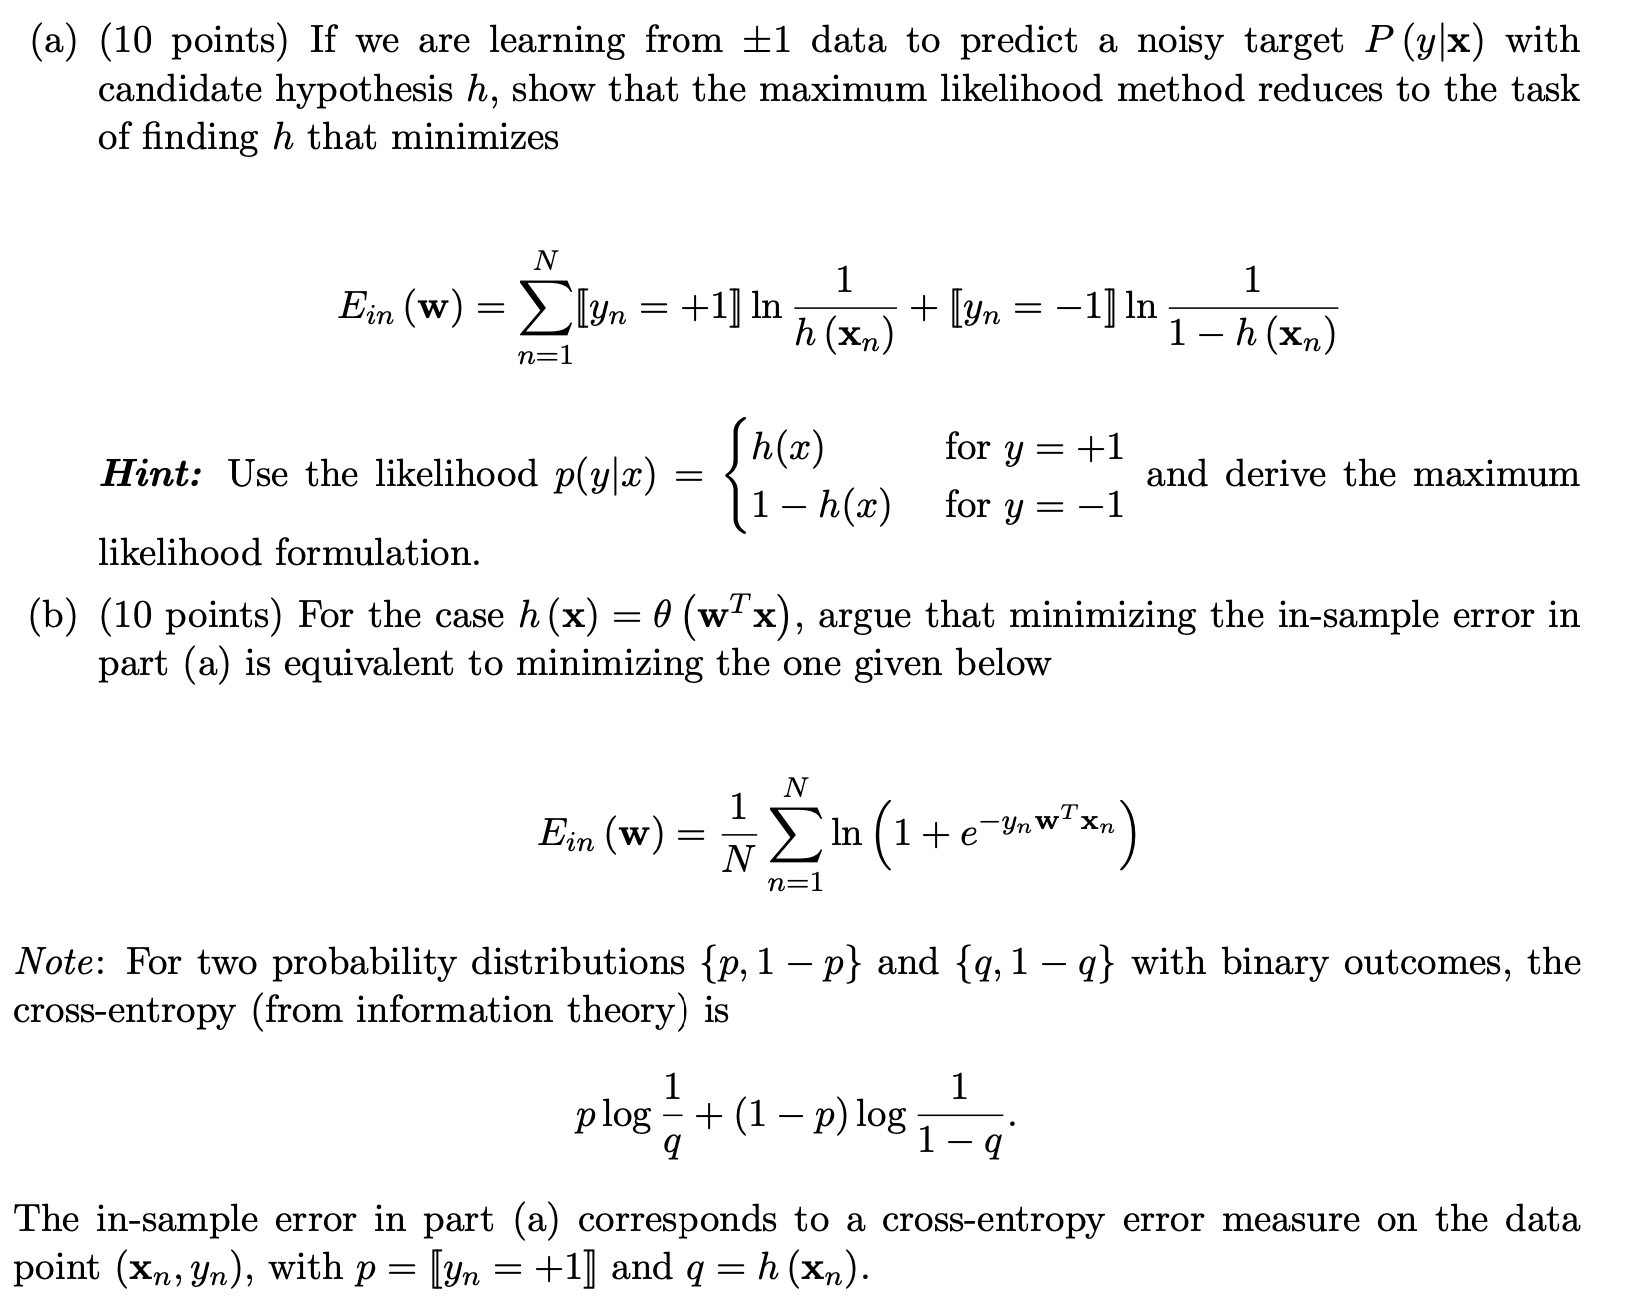

(a) likelihood is $\mathcal{L} = \prod_i p(y_i | \mathbf{x}_i)$

log-likelihood is $\log \mathcal{L} = \sum_i \log p(y_i | \mathbf{x}_i)$

We have $p(y | \mathbf{x}) = h(\mathbf{x})$ if $y = +1$ and $p(y | \mathbf{x}) = 1- h(\mathbf{x})$ if $y = -1$

So if we sum over all $i$, we get a $\log h$ term for positive labels and a $\log (1 - h)$ term for negative labels.

Maximizing the log-likelihood is the same as minimizing the negative log-likelihood. So we put a minus sign in front of sum to get the negative log likelihood, and we use $-\log(A) = \log(1/A)$. From there, we get the $E$ expression listed!

(b) for $h(\mathbf{x}) = \theta(\mathbf{w}^T\mathbf{x})$, with $\theta(a) = \frac{1}{1 + e^{-a}}$, note that

if $y = +1$, $h(\mathbf{x}) = \theta(\mathbf{w}^T\mathbf{x})$. If $y = -1$, $h(\mathbf{x}) = 1-\theta(\mathbf{w}^T\mathbf{x}) = \frac{e^{-\mathbf{w}^T\mathbf{x}}}{1 + e^{-\mathbf{w}^T\mathbf{x}}} = \frac{1}{1 + e^{\mathbf{w}^T\mathbf{x}}}$

Or, more succinctly, $h(\mathbf{x}) = \frac{1}{1 + e^{-y \mathbf{w}^T\mathbf{x}}}$, which is general for any sign of y.

From this expression, we can just take the log-likelihood which is $-\ln(h) = \ln\left(1 + e^{-y\mathbf{w}^T\mathbf{x}}\right)$, which is what we were seeking.

# Problem 2
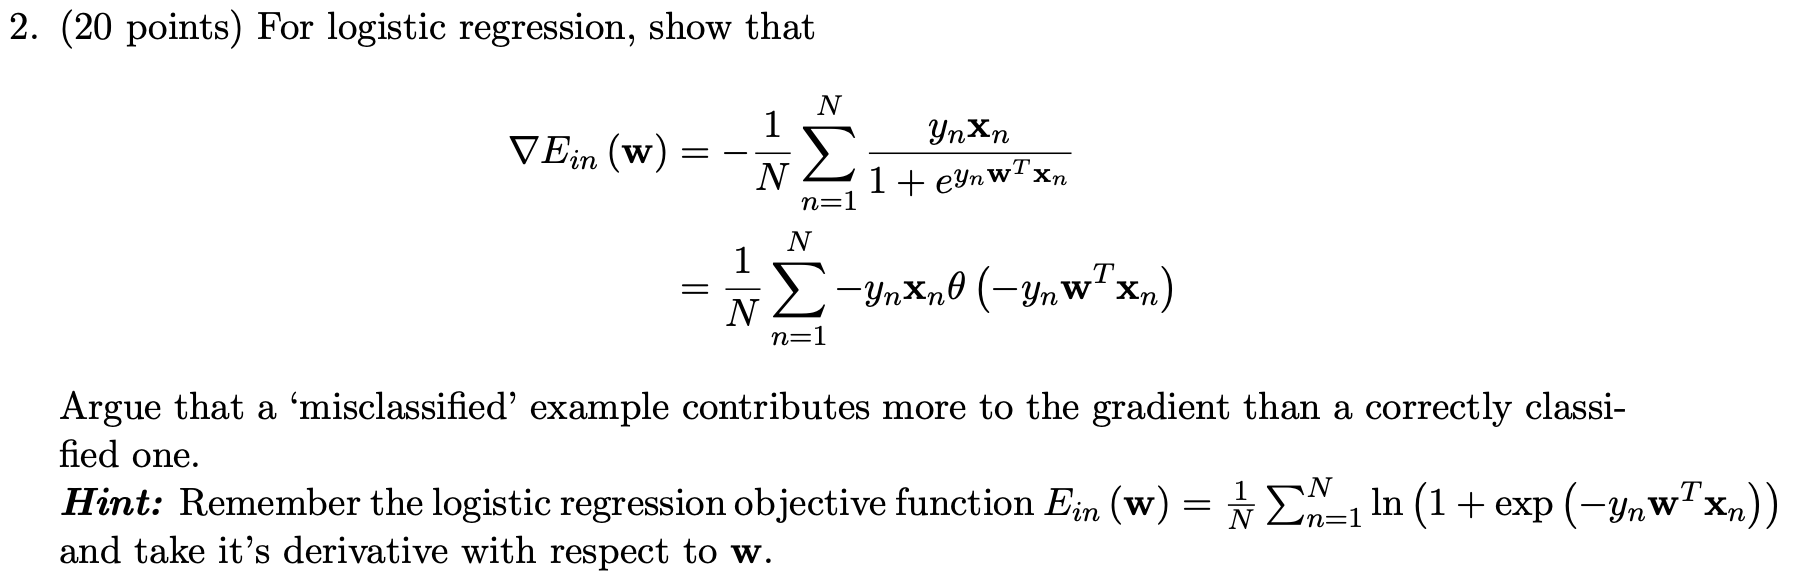

(a) Starting from $E_{in} = \frac{1}{N}\sum_{i=1}^N \ln \left(1 + e^{-y_n \mathbf{w}^T \mathbf{x}_n}\right)$, we take a derivative w.r.t. $\mathbf{x}$.

Derivative of a natural log is 1/(arguments) times derivative (arguments) so $\nabla \ln \left(1 + e^{-y_n \mathbf{w}^T \mathbf{x}_n}\right) = \frac{1}{1 + e^{-y_n \mathbf{w}^T \mathbf{x}_n}}\nabla e^{-y_n \mathbf{w}^T \mathbf{x}_n} = \frac{1}{1 + e^{-y_n \mathbf{w}^T \mathbf{x}_n}}e^{-y_n \mathbf{w}^T \mathbf{x}_n} \nabla(-y_n \mathbf{w}^T \mathbf{x}_n) = \frac{1}{1 + e^{-y_n \mathbf{w}^T \mathbf{x}_n}}e^{-y_n \mathbf{w}^T \mathbf{x}_n} (-y_n \mathbf{x}_n)$.

Multiplying the top and bottom by $e^{y_n \mathbf{w}^T \mathbf{x}_n}$, we arrive at the desired answer:
$\nabla E_{in} = -\frac{1}{N}\sum_{i=1}^N \frac{y_n \mathbf{x}_n}{1 + e^{y_n \mathbf{w}^T \mathbf{x}_n}} = 
-\frac{1}{N}\sum_{i=1}^N y_n \mathbf{x}_n \theta(y_n \mathbf{w}^T \mathbf{x}_n)$, where the last part comes from the definition of the sigmoid function $\theta$.

(b) In a correctly classified example, $y_n \mathbf{w}^T \mathbf{x}_n > 0$, whereas in an incorrectly classified example, $y_n \mathbf{w}^T \mathbf{x}_n < 0$. The sigmoid function $\theta$ goes from 0 (at $-\infty$) to 1 (at $+\infty$), so the sigmoid function amplifies misclassified examples since its argument is $-y_n \mathbf{w}^T \mathbf{x}_n$.

# Problem 3
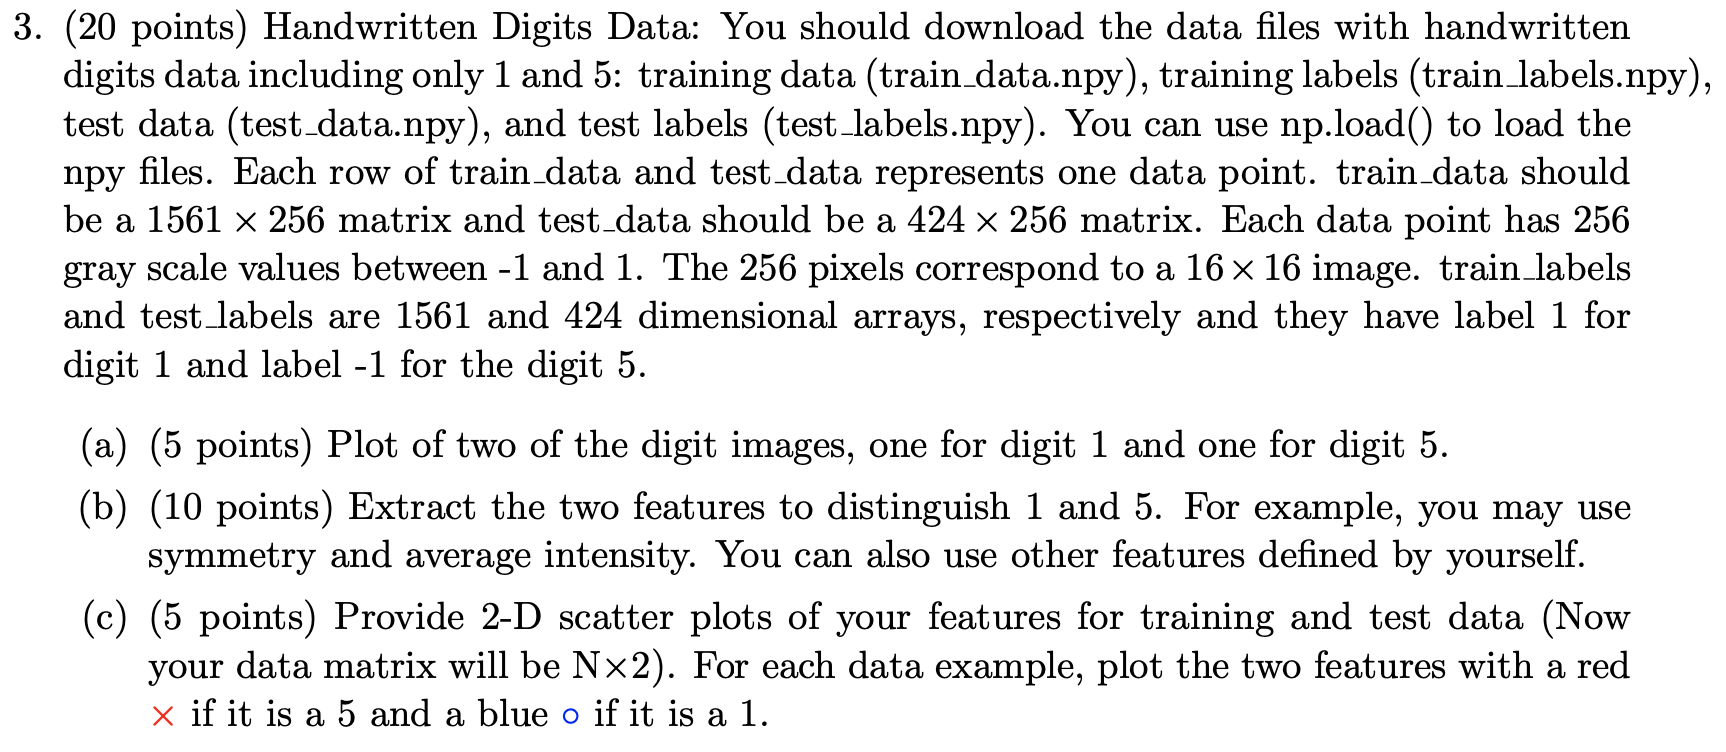

In [41]:
# Load MNIST and split into train and test
mnist = load_dataset('mnist')

train = mnist['train']
labels = np.array(train['label'])
good = np.logical_or(labels == 1, labels == 5)
train = train.select(np.arange(labels.size)[good])

test = mnist['test']
labels = np.array(test['label'])
good = np.logical_or(labels == 1, labels == 5)
test = test.select(np.arange(labels.size)[good])

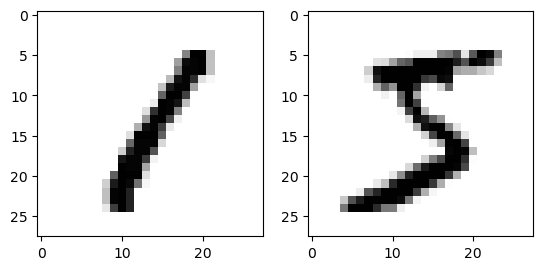

In [54]:
#(a) plot a 1 and a 5
fig, axs = plt.subplots(1, 2)

one_indices = np.where(np.array(train['label']) == 1)[0]
five_indices = np.where(np.array(train['label']) == 5)[0]

one_img = train['image'][one_indices[0]]
axs[0].imshow(one_img, cmap='gray_r')

five_img = train['image'][five_indices[0]]
axs[1].imshow(five_img, cmap='gray_r')


In [84]:
#extract features: symmetry, intensity


def extract_features(dataset):
    images = np.array(dataset['image'])
    labels = np.array(dataset['label'])
    n_pix = images.shape[1]
    flat_images = images.reshape(images.shape[0], -1)

    img_avg = np.mean(flat_images, axis=1)

    #symmetry (top-down, left-right)
    left = images[:, :n_pix//2]
    right = images[:, n_pix//2:]
    top = images[:, :, :n_pix//2]
    bottom = images[:, :, n_pix//2:]

    lr_sym = np.mean(np.abs(left - right[:,::-1]), axis=(1, 2))
    tb_sym = np.mean(np.abs(top - bottom[:,:,::-1]), axis=(1, 2))

    return labels, np.stack([img_avg, lr_sym, tb_sym], axis=1)

test_labels, test_features = extract_features(test)
train_labels, train_features = extract_features(train)
print(train_features.shape)

(12163, 3)


Text(0, 0.5, 'Left-Right Symmetry')

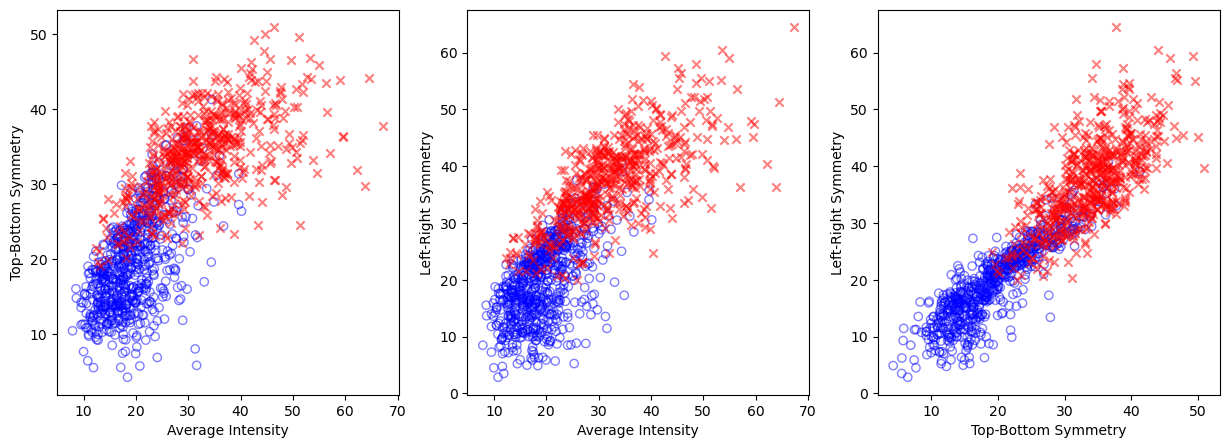

In [85]:
# 3 scatterplots: intensity vs tb symmetry, intensity vs lr symmetry, tb symmetry vs lr symmetry
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

img_avg = train_features[:, 0]
lr_sym = train_features[:, 1]
tb_sym = train_features[:, 2]
axs[0].scatter(img_avg[one_indices][::10], tb_sym[one_indices][::10], edgecolor='b', marker='o', facecolors='none', alpha=0.5)
axs[0].scatter(img_avg[five_indices][::10], tb_sym[five_indices][::10], c='r', marker='x', alpha=0.5)
axs[0].set_xlabel('Average Intensity')
axs[0].set_ylabel('Top-Bottom Symmetry')

axs[1].scatter(img_avg[one_indices][::10], lr_sym[one_indices][::10], edgecolor='b', marker='o', facecolors='none', alpha=0.5)
axs[1].scatter(img_avg[five_indices][::10], lr_sym[five_indices][::10], c='r', marker='x', alpha=0.5)
axs[1].set_xlabel('Average Intensity')
axs[1].set_ylabel('Left-Right Symmetry')

axs[2].scatter(tb_sym[one_indices][::10], lr_sym[one_indices][::10], edgecolor='b', marker='o', facecolors='none', alpha=0.5)
axs[2].scatter(tb_sym[five_indices][::10], lr_sym[five_indices][::10], c='r', marker='x', alpha=0.5)
axs[2].set_xlabel('Top-Bottom Symmetry')
axs[2].set_ylabel('Left-Right Symmetry')

Text(0, 0.5, 'Left-Right Symmetry')

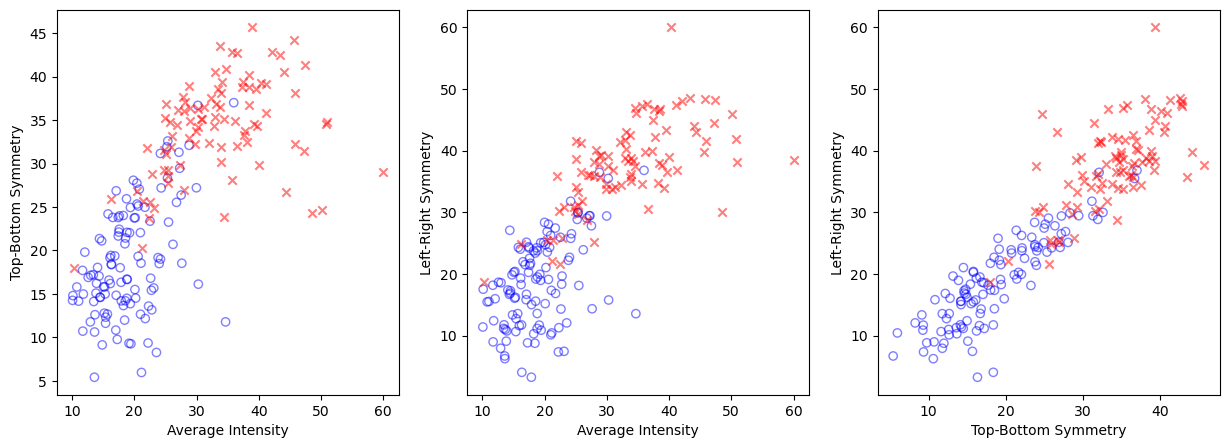

In [90]:
# 3 scatterplots: intensity vs tb symmetry, intensity vs lr symmetry, tb symmetry vs lr symmetry
# Same as above but for test set
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

img_avg = test_features[:, 0]
lr_sym = test_features[:, 1]
tb_sym = test_features[:, 2]

test_one_indices = np.where(np.array(test['label']) == 1)[0]
test_five_indices = np.where(np.array(test['label']) == 5)[0]

axs[0].scatter(img_avg[test_one_indices][::10], tb_sym[test_one_indices][::10], edgecolor='b', marker='o', facecolors='none', alpha=0.5)
axs[0].scatter(img_avg[test_five_indices][::10], tb_sym[test_five_indices][::10], c='r', marker='x', alpha=0.5)
axs[0].set_xlabel('Average Intensity')
axs[0].set_ylabel('Top-Bottom Symmetry')

axs[1].scatter(img_avg[test_one_indices][::10], lr_sym[test_one_indices][::10], edgecolor='b', marker='o', facecolors='none', alpha=0.5)
axs[1].scatter(img_avg[test_five_indices][::10], lr_sym[test_five_indices][::10], c='r', marker='x', alpha=0.5)
axs[1].set_xlabel('Average Intensity')
axs[1].set_ylabel('Left-Right Symmetry')

axs[2].scatter(tb_sym[test_one_indices][::10], lr_sym[test_one_indices][::10], edgecolor='b', marker='o', facecolors='none', alpha=0.5)
axs[2].scatter(tb_sym[test_five_indices][::10], lr_sym[test_five_indices][::10], c='r', marker='x', alpha=0.5)
axs[2].set_xlabel('Top-Bottom Symmetry')
axs[2].set_ylabel('Left-Right Symmetry')

# Problem 4
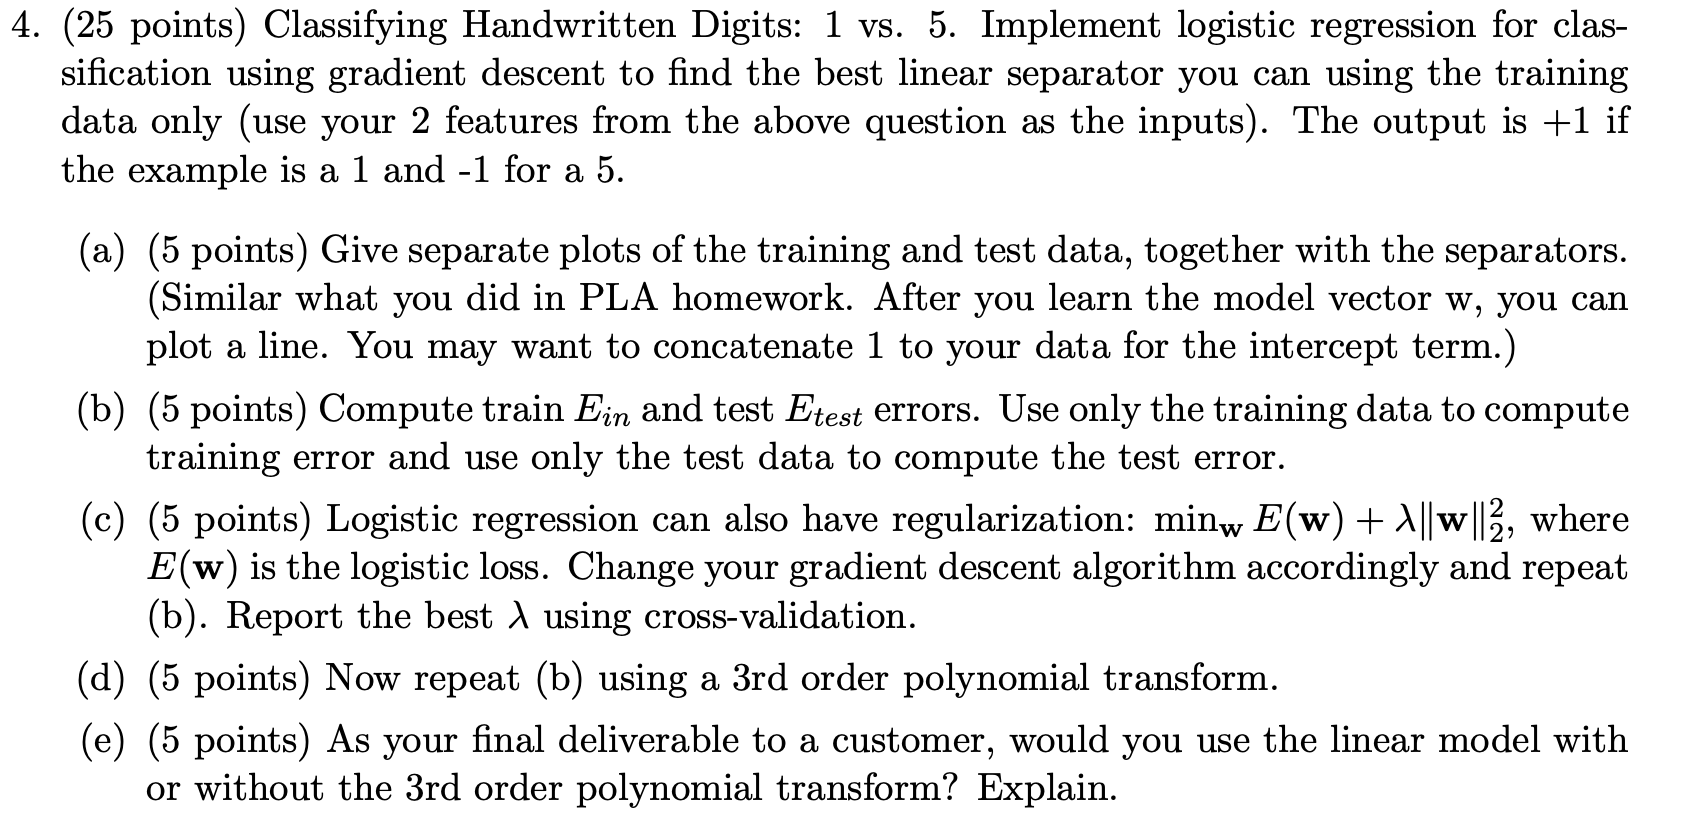

# Problem 5
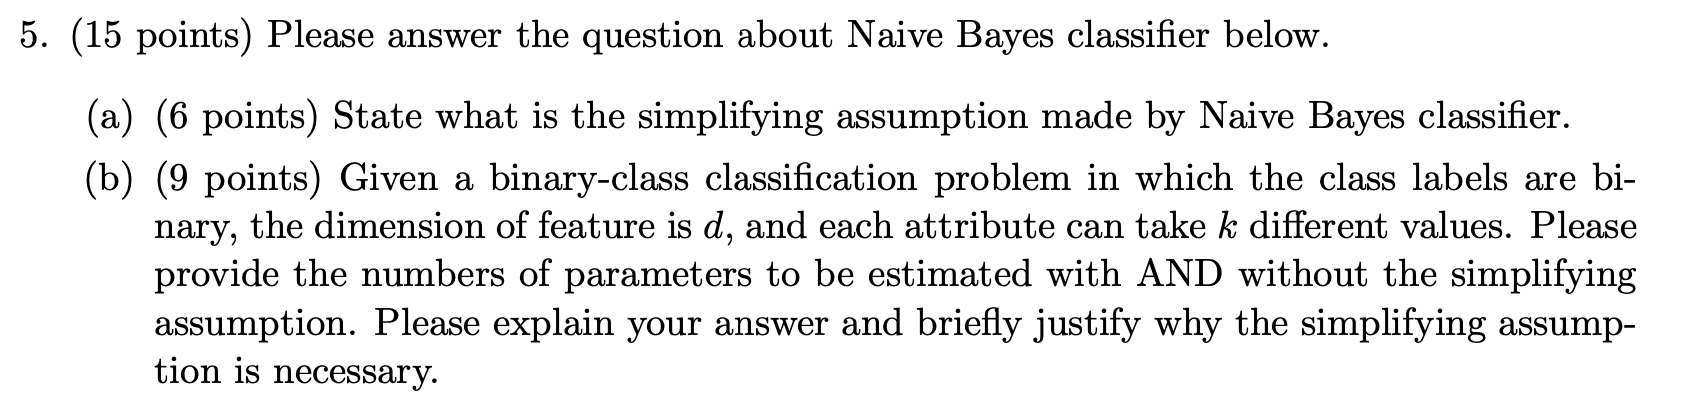